<a href="https://colab.research.google.com/github/andrealamanna/cnn_prediction_abnormalities_mammography/blob/main/Pretrained_CNN_MassCalc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 3**
## Pretrained CNN for masses/calcifications classifications

#Perliminar phases

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import os 
import gc # Garbage Collector
from skimage import data, img_as_float
from skimage import exposure

from tensorflow import keras
from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from keras import layers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

print("Done")

Done


In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
#PAT = 4

METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

base_path = "/content/gdrive/My Drive/Colab Notebooks/DLProject/Lamanna/"

MODEL_PATH = os.path.join(base_path, "models/Pretrained")
PLOTS_PATH = os.path.join(base_path, "plots/Pretrained")
#MODEL_PATH = os.path.join(base_path, "localmodels/Pretrained")
#PLOTS_PATH = os.path.join(base_path, "localplots/Pretrained")
RESULT_PATH = os.path.join(base_path, "results/Masses-Calcifications/Scratch")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

#file_path_out = os.path.join(RESULT_PATH, "top3_results.csv")
#file_path = os.path.join(RESULT_PATH, "results-CM.csv")
#model_path = os.path.join(MODEL_PATH, "best_model.h5")

print("Done")

Done


# Utility Functions

In [ ]:
# Remove baseline samples
def remove_baseline(samples): 
  max_index = int(len(samples)/2)
  indexes = [2*i + 1 for i in range(0, max_index)]

  return samples[indexes]

# Interchange the dataset index
def shuffle_dataset(i, j):
  indexes = tf.range(start=0, limit=tf.shape(i)[0], dtype=tf.int32)
  shuffled_indexes = tf.random.shuffle(indexes)

  i = tf.gather(i, shuffled_indexes)
  j = tf.gather(j, shuffled_indexes)

  i = i.numpy()
  j = j.numpy()

  return i, j

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

Done


In [ ]:
#test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
def test_model(model):
  test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)#,
                                      #callbacks=[GarbageCollectorCallback()])
  print("\n---------------------------------")
  print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
  print("Loss:", "%0.2f" % (test_loss))
  #print("Precision:", "%0.2f" % (test_precision*100), "%")
  #print("Recall:", "%0.2f" % (test_recall*100), "%")
  #print("AUC:", "%0.2f" % test_auc)
  print("---------------------------------\n")

print("Done")

Done


In [ ]:
def print_opt_results(history_0):
  # History of accuracy and loss
  tra_loss_0 = history_0.history['loss']
  tra_acc_0 = history_0.history['acc']
  val_loss_0 = history_0.history['val_loss']
  val_acc_0 = history_0.history['val_acc']

  # Total number of epochs training
  epochs_0 = range(1, len(tra_acc_0)+1)
  end_epoch_0 = len(tra_acc_0)

  # Epoch when reached the val acc max
  opt_epoch_0 = val_acc_0.index(max(val_acc_0)) + 1

  # Loss and accuracy on the validation set
  end_val_loss_0 = val_loss_0[len(val_loss_0)-1]
  end_val_acc_0 = val_acc_0[len(val_acc_0)-1]
  opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
  opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

  print("Epoch [end]: %d" % end_epoch_0)
  print("Epoch [opt]: %d" % opt_epoch_0)
  print("Valid accuracy [end]: %.4f" % end_val_acc_0)
  print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
  print("Valid loss [end]: %.4f" % end_val_loss_0)
  print("Valid loss [opt]: %.4f" % opt_val_loss_0)

print("Done")

Done


In [ ]:
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  #loss = history.history['loss']
  #val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.figure()
  plt.plot(epochs, acc, 'b', linestyle='dashed', label='Training accuracy',color='Green')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='Blue')
  plt.title('Training and validation accuracy')
  plt.legend()
  return plt

def plot_loss(history):
  #acc = history.history['acc']
  #val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', linestyle='dashed', label='Training loss',color='cyan')
  plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
  plt.title('Training and validation loss')
  plt.legend()
  return plt

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    precision = TP / (TP + FP)

    tpr = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity
    # Visualization Data Histogram

def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=BATCH_SIZE+1,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

print("Done")

Done


In [ ]:
#Early stop conditon 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PAT)

In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
#class GarbageCollectorCallback(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#      gc.collect()

#print("Done")

In [ ]:
def earlyStop(patience):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  return callback
print("Done")

Done


# Data operations

In [ ]:
train_images = np.load(train_img_path)
train_labels = np.load(train_label_path)
test_images = np.load(test_img_path)
test_labels = np.load(test_label_path)

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)
print("Train dataset")
print("---------------------------------")
print("Masses: \t\t", counts[1]+counts[2])
print("Calcification: \t\t", counts[3]+counts[4])
print("---------------------------------")
print("Benign: \t\t", counts[1]+counts[3])
print("Malign: \t\t", counts[2]+counts[4])
print("---------------------------------")
print("Benign Masses: \t\t", counts[1])
print("Malign Masses: \t\t", counts[2])
print("Benign Calcification: \t", counts[3])
print("Malign Calcification: \t", counts[4])
print("---------------------------------")
print("Baseline: \t\t", counts[0])
print("---------------------------------")
print("Total: \t\t\t", counts[0]+counts[1]+counts[2]+counts[3]+counts[4])

#count quantity masses and calcifications
uniqueT, countsT = np.unique(test_labels, return_counts=True)
#print(unique, countsT)
print("\n")
print("Test dataset")
print("---------------------------------")
print("Masses: \t\t", countsT[1]+countsT[2])
print("Calcification: \t\t", countsT[3]+countsT[4])
print("---------------------------------")
print("Benign: \t\t", countsT[1]+countsT[3])
print("Malign: \t\t", countsT[2]+countsT[4])
print("---------------------------------")
print("Benign Masses: \t\t", countsT[1])
print("Malign Masses: \t\t", countsT[2])
print("Benign Calcification: \t", countsT[3])
print("Malign Calcification: \t", countsT[4])
print("---------------------------------")
print("Baseline: \t\t", countsT[0])
print("---------------------------------")
print("Total: \t\t\t", countsT[0]+countsT[1]+countsT[2]+countsT[3]+countsT[4])

Train dataset
---------------------------------
Masses: 		 1218
Calcification: 		 1458
---------------------------------
Benign: 		 1568
Malign: 		 1108
---------------------------------
Benign Masses: 		 620
Malign Masses: 		 598
Benign Calcification: 	 948
Malign Calcification: 	 510
---------------------------------
Baseline: 		 2676
---------------------------------
Total: 			 5352


Test dataset
---------------------------------
Masses: 		 179
Calcification: 		 157
---------------------------------
Benign: 		 219
Malign: 		 117
---------------------------------
Benign Masses: 		 113
Malign Masses: 		 66
Benign Calcification: 	 106
Malign Calcification: 	 51
---------------------------------
Baseline: 		 336
---------------------------------
Total: 			 672


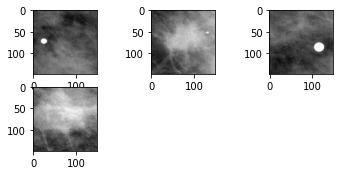

In [ ]:
images = range(0,4)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


In [ ]:
train_images8bit = (train_images/256).astype('uint8')
test_images8bit = (test_images/256).astype('uint8')

In [ ]:
print("max=",train_images8bit.max())
print("min=",train_images8bit.min())
for i in range(2):
  print(train_images8bit[i])
  print(test_images8bit[i])
print("max=",train_images.max())
print("min=",train_images.min())
for i in range(2):
  print(train_images[i])
  print(test_images[i])

max= 255
min= 0
[[143 141 144 ... 141 144 145]
 [141 141 143 ... 146 143 141]
 [136 137 140 ... 149 152 146]
 ...
 [143 146 145 ... 152 148 153]
 [145 147 142 ... 149 148 151]
 [140 141 145 ... 149 144 146]]
[[  0   0   5 ... 103 103 106]
 [  0   0   0 ... 105 103 107]
 [  0   0   0 ... 101 106 106]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[117 117 117 ... 164 164 162]
 [119 119 119 ... 160 162 160]
 [116 116 117 ... 163 162 160]
 ...
 [128 129 128 ... 146 147 147]
 [127 129 129 ... 146 145 144]
 [124 123 125 ... 146 148 148]]
[[ 97  98  97 ... 153 154 156]
 [ 98  99  97 ... 153 155 156]
 [ 97  99  95 ... 153 152 155]
 ...
 [108 107 109 ... 128 126 126]
 [104 106 104 ... 127 125 125]
 [110 106 107 ... 131 128 127]]
max= 65535
min= 0
[[36747 36328 37077 ... 36218 36923 37341]
 [36108 36196 36725 ... 37473 36725 36152]
 [34897 35227 36020 ... 38266 38948 37605]
 ...
 [36614 37429 37297 ... 38970 38024 39411]
 [37319 37759 36416 .

In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))
train_images8bit = train_images8bit.reshape(train_images8bit.shape + (1,))
test_images8bit = test_images8bit.reshape(test_images8bit.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)


In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Masses samples: ", counts[0])
print("Calcifications samples: ", counts[1])

Masses samples:  1218
Calcifications samples:  1458


In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_images))
train_dataset_split = train_images[:split_index]
valid_dataset_split = train_images[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]
train_dataset_split8bit = train_images8bit[:split_index]
valid_dataset_split8bit = train_images8bit[split_index:]

print(train_dataset_split.shape)
print(valid_dataset_split.shape)

(2140, 150, 150, 1)
(536, 150, 150, 1)


In [ ]:
# All images will be rescaled by 1./65535 (max value range)
#train_datagen = ImageDataGenerator(rescale=1./65535)
#valid_datagen = ImageDataGenerator(rescale=1./65535)
#test_datagen = ImageDataGenerator(rescale=1./65535)

In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
#train_datagen = ImageDataGenerator(
#    rescale=1./65535,
#    rotation_range=40,
#    width_shift_range=0.25,
#    height_shift_range=0.25,
#    shear_range=0.5,
#    zoom_range=0.5, #0.5 - 1.5
#    horizontal_flip=True,
#    fill_mode='nearest')

In [ ]:
train_dataset_split = np.repeat(train_dataset_split, 3, axis = 3)
valid_dataset_split = np.repeat(valid_dataset_split, 3, axis = 3)
train_dataset_split8bit = np.repeat(train_dataset_split8bit, 3, axis = 3)
valid_dataset_split8bit = np.repeat(valid_dataset_split8bit, 3, axis = 3)
test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_dataset_split.shape)
print(test_images.shape)


(2140, 150, 150, 3)
(336, 150, 150, 3)


# **CNN Definition**

##Inception V3

In [ ]:
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [ ]:
#train_dataset_split=preprocess_input(train_dataset_split)
#valid_dataset_split=preprocess_input(valid_dataset_split)
#test_images=preprocess_input(test_images)

In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
train_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest'
   )

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)

In [ ]:
train_datagen8bit = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest'
   )

In [ ]:
valid_datagen8bit = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen8bit = ImageDataGenerator(preprocessing_function=preprocess_input)

###Model 0
Trying the best approch:


1.   Rescaling image in range [0,1] (like in  sctratch execution)
2.   Using preprocess_input function for InceptionV3 (8bits numbers rescaled in range [-1,1]

We use less epochs for this purpose: we want to see wich solution performs better

In [ ]:
callback=earlyStop(10)

In [ ]:
model0 = models.Sequential()
model0.add(conv_base)
model0.add(layers.Flatten())
model0.add(layers.Dense(512, activation='relu'))
model0.add(layers.Dropout(0.2))
model0.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model0.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

####Model 0.1

In [ ]:
history01 = model0.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=50,
                    callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/50
33/33 [==============================] - 35s 900ms/step - loss: 2.1601 - acc: 0.6488 - val_loss: 0.4395 - val_acc: 0.8066
Epoch 2/50
33/33 [==============================] - 24s 737ms/step - loss: 0.7887 - acc: 0.7115 - val_loss: 0.3760 - val_acc: 0.8418
Epoch 3/50
33/33 [==============================] - 16s 467ms/step - loss: 0.5490 - acc: 0.7717 - val_loss: 0.4963 - val_acc: 0.7480
Epoch 4/50
33/33 [==============================] - 14s 433ms/step - loss: 0.5249 - acc: 0.7645 - val_loss: 0.4008 - val_acc: 0.8105
Epoch 5/50
33/33 [==============================] - 14s 429ms/step - loss: 0.4915 - acc: 0.7823 - val_loss: 0.3987 - val_acc: 0.8301
Epoch 6/50
33/33 [==============================] - 15s 450ms/step - loss: 0.4966 - acc: 0.7837 - val_loss: 0.3447 - val_acc: 0.8574
Epoch 7/50
33/33 [==============================] - 14s 429ms/step - loss: 0.4716 - acc: 0.7881 - val_loss: 0.3771 - val_acc: 0.8379
Epoch 8/50
33/33 [==============================] - 14s 434ms/step - 

In [ ]:
model0.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model01.h5'))

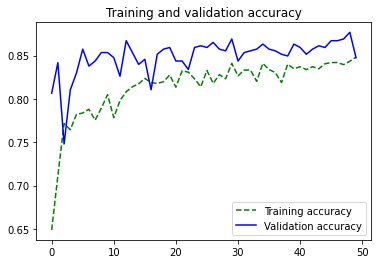

In [ ]:
plt_a = plot_acc(history01)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model01_acc.png'))
plt_a.show()

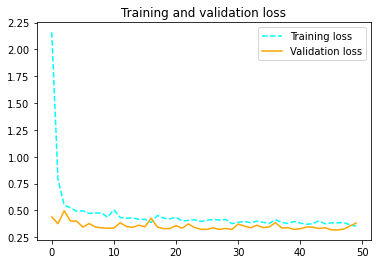

In [ ]:
plt_l = plot_loss(history01)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model01_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history01)

Epoch [end]: 50
Epoch [opt]: 49
Valid accuracy [end]: 0.8477
Valid accuracy [opt]: 0.8770
Valid loss [end]: 0.3820
Valid loss [opt]: 0.3543


In [ ]:
test_model(model0)

5/5 [==============================] - 1s 158ms/step - loss: 0.3704 - acc: 0.8531

---------------------------------
Accuracy: 85.31 %
Loss: 0.37
---------------------------------



####Model 0.2

In [ ]:
history02 = model0.fit(train_datagen8bit.flow(train_dataset_split8bit,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split8bit) // BATCH_SIZE, 
                    epochs=50,
                    callbacks=[callback],
                    validation_data=valid_datagen8bit.flow(valid_dataset_split8bit,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_dataset_split8bit) // BATCH_SIZE)

Epoch 1/50
33/33 [==============================] - 14s 419ms/step - loss: 0.5907 - acc: 0.7866 - val_loss: 0.3903 - val_acc: 0.8320
Epoch 2/50
33/33 [==============================] - 24s 730ms/step - loss: 0.4369 - acc: 0.8092 - val_loss: 0.3667 - val_acc: 0.8457
Epoch 3/50
33/33 [==============================] - 14s 415ms/step - loss: 0.4452 - acc: 0.8256 - val_loss: 0.3691 - val_acc: 0.8320
Epoch 4/50
33/33 [==============================] - 14s 412ms/step - loss: 0.4165 - acc: 0.8232 - val_loss: 0.4028 - val_acc: 0.8379
Epoch 5/50
33/33 [==============================] - 14s 409ms/step - loss: 0.4198 - acc: 0.8155 - val_loss: 0.4235 - val_acc: 0.8320
Epoch 6/50
33/33 [==============================] - 14s 408ms/step - loss: 0.4309 - acc: 0.8261 - val_loss: 0.3685 - val_acc: 0.8457
Epoch 7/50
33/33 [==============================] - 14s 411ms/step - loss: 0.4215 - acc: 0.8266 - val_loss: 0.4097 - val_acc: 0.8379
Epoch 8/50
33/33 [==============================] - 14s 414ms/step - 

In [ ]:
model0.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model02.h5'))

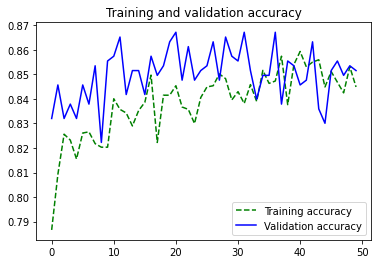

In [ ]:
plt_a = plot_acc(history02)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model02_acc.png'))
plt_a.show()

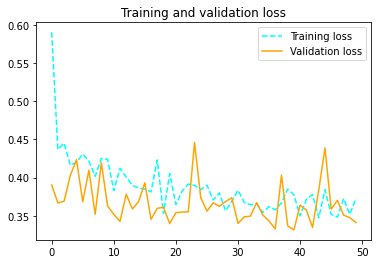

In [ ]:
plt_l = plot_loss(history02)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model02_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history02)

Epoch [end]: 50
Epoch [opt]: 21
Valid accuracy [end]: 0.8516
Valid accuracy [opt]: 0.8672
Valid loss [end]: 0.3410
Valid loss [opt]: 0.3541


In [ ]:
test_model(model0)

5/5 [==============================] - 1s 164ms/step - loss: 0.4085 - acc: 0.8313

---------------------------------
Accuracy: 83.13 %
Loss: 0.41
---------------------------------



###Model 1
earlystopping with patience = 15

In [ ]:
callback=earlyStop(15)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 36s 806ms/step - loss: 1.9914 - acc: 0.6431 - val_loss: 0.4262 - val_acc: 0.8105
Epoch 2/100
33/33 [==============================] - 14s 415ms/step - loss: 0.6359 - acc: 0.7317 - val_loss: 0.3807 - val_acc: 0.8457
Epoch 3/100
33/33 [==============================] - 14s 411ms/step - loss: 0.5383 - acc: 0.7616 - val_loss: 0.3984 - val_acc: 0.8184
Epoch 4/100
33/33 [==============================] - 14s 412ms/step - loss: 0.5043 - acc: 0.7707 - val_loss: 0.3535 - val_acc: 0.8633
Epoch 5/100
33/33 [==============================] - 14s 436ms/step - loss: 0.4902 - acc: 0.7765 - val_loss: 0.3505 - val_acc: 0.8477
Epoch 6/100
33/33 [==============================] - 14s 410ms/step - loss: 0.4742 - acc: 0.7996 - val_loss: 0.3341 - val_acc: 0.8535
Epoch 7/100
33/33 [==============================] - 14s 420ms/step - loss: 0.4535 - acc: 0.7934 - val_loss: 0.3468 - val_acc: 0.8516
Epoch 8/100
33/33 [==============================] - 14s 415ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model1.h5'))

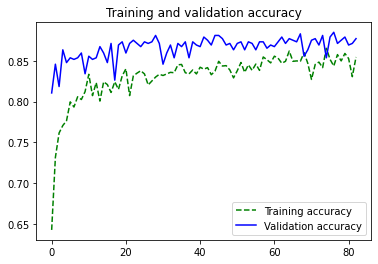

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model1_acc.png'))
plt_a.show()

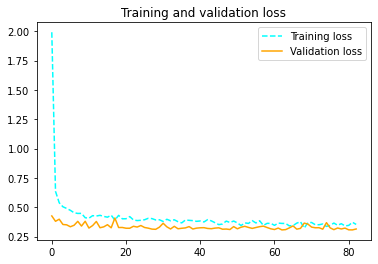

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model1_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 83
Epoch [opt]: 77
Valid accuracy [end]: 0.8770
Valid accuracy [opt]: 0.8848
Valid loss [end]: 0.3152
Valid loss [opt]: 0.3094


In [ ]:
test_model(model)

5/5 [==============================] - 1s 159ms/step - loss: 0.3416 - acc: 0.8531

---------------------------------
Accuracy: 85.31 %
Loss: 0.34
---------------------------------



###Model 2
Less node in dense layer and dropout 0.2 and early stopping with patience=25

In [ ]:
callback=earlyStop(25)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 18432)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               4718848   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 20s 464ms/step - loss: 1.1365 - acc: 0.6623 - val_loss: 0.4518 - val_acc: 0.8008
Epoch 2/100
33/33 [==============================] - 14s 410ms/step - loss: 0.5606 - acc: 0.7514 - val_loss: 0.3627 - val_acc: 0.8496
Epoch 3/100
33/33 [==============================] - 14s 411ms/step - loss: 0.4879 - acc: 0.7847 - val_loss: 0.3433 - val_acc: 0.8516
Epoch 4/100
33/33 [==============================] - 14s 410ms/step - loss: 0.4595 - acc: 0.7977 - val_loss: 0.3594 - val_acc: 0.8496
Epoch 5/100
33/33 [==============================] - 14s 411ms/step - loss: 0.4425 - acc: 0.8015 - val_loss: 0.3524 - val_acc: 0.8438
Epoch 6/100
33/33 [==============================] - 13s 407ms/step - loss: 0.4650 - acc: 0.7938 - val_loss: 0.3541 - val_acc: 0.8418
Epoch 7/100
33/33 [==============================] - 14s 419ms/step - loss: 0.4420 - acc: 0.8088 - val_loss: 0.3543 - val_acc: 0.8496
Epoch 8/100
33/33 [==============================] - 14s 423ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model2.h5'))

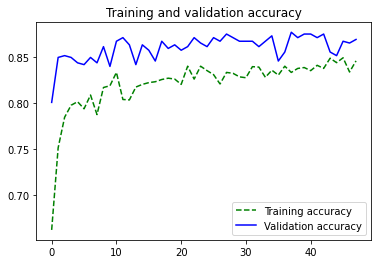

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model2_acc.png'))
plt_a.show()

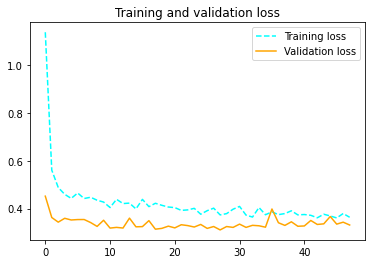

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model2_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 48
Epoch [opt]: 38
Valid accuracy [end]: 0.8691
Valid accuracy [opt]: 0.8770
Valid loss [end]: 0.3313
Valid loss [opt]: 0.3297


In [ ]:
test_model(model)

5/5 [==============================] - 1s 162ms/step - loss: 0.3616 - acc: 0.8344

---------------------------------
Accuracy: 83.44 %
Loss: 0.36
---------------------------------



###Model 3
Model1 with dropout 0.5 and early stopping with patience=15

In [ ]:
callback=earlyStop(15)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 18432)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               9437696   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 20s 459ms/step - loss: 1.4925 - acc: 0.6816 - val_loss: 0.4067 - val_acc: 0.8398
Epoch 2/100
33/33 [==============================] - 13s 406ms/step - loss: 0.5741 - acc: 0.7683 - val_loss: 0.3483 - val_acc: 0.8691
Epoch 3/100
33/33 [==============================] - 21s 625ms/step - loss: 0.6103 - acc: 0.7495 - val_loss: 0.3456 - val_acc: 0.8691
Epoch 4/100
33/33 [==============================] - 13s 405ms/step - loss: 0.5314 - acc: 0.7741 - val_loss: 0.3949 - val_acc: 0.8262
Epoch 5/100
33/33 [==============================] - 20s 614ms/step - loss: 0.4940 - acc: 0.7799 - val_loss: 0.3435 - val_acc: 0.8652
Epoch 6/100
33/33 [==============================] - 18s 547ms/step - loss: 0.5087 - acc: 0.7794 - val_loss: 0.3500 - val_acc: 0.8555
Epoch 7/100
33/33 [==============================] - 13s 406ms/step - loss: 0.4869 - acc: 0.7929 - val_loss: 0.3571 - val_acc: 0.8516
Epoch 8/100
33/33 [==============================] - 13s 405ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model3.h5'))

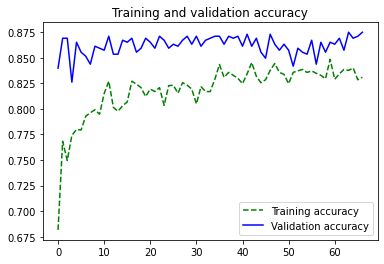

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model3_acc.png'))
plt_a.show()

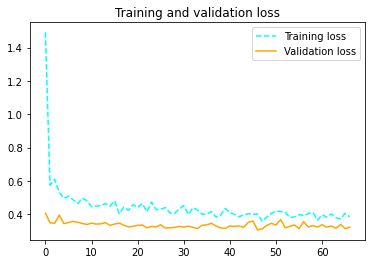

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model3_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 67
Epoch [opt]: 64
Valid accuracy [end]: 0.8750
Valid accuracy [opt]: 0.8750
Valid loss [end]: 0.3224
Valid loss [opt]: 0.3159


In [ ]:
test_model(model)

5/5 [==============================] - 1s 161ms/step - loss: 0.3851 - acc: 0.8281

---------------------------------
Accuracy: 82.81 %
Loss: 0.39
---------------------------------



###Model 3.1
Model1 without dropout and early stopping with patience=15

In [ ]:
callback=earlyStop(25)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 32s 517ms/step - loss: 1.9887 - acc: 0.6705 - val_loss: 1.0404 - val_acc: 0.5957
Epoch 2/100
33/33 [==============================] - 14s 425ms/step - loss: 0.7288 - acc: 0.7182 - val_loss: 0.4490 - val_acc: 0.8125
Epoch 3/100
33/33 [==============================] - 14s 428ms/step - loss: 0.5562 - acc: 0.7673 - val_loss: 0.3723 - val_acc: 0.8496
Epoch 4/100
33/33 [==============================] - 15s 450ms/step - loss: 0.5672 - acc: 0.7755 - val_loss: 0.4339 - val_acc: 0.7949
Epoch 5/100
33/33 [==============================] - 14s 421ms/step - loss: 0.4851 - acc: 0.7982 - val_loss: 0.4058 - val_acc: 0.8105
Epoch 6/100
33/33 [==============================] - 14s 424ms/step - loss: 0.5107 - acc: 0.7871 - val_loss: 0.3509 - val_acc: 0.8516
Epoch 7/100
33/33 [==============================] - 14s 424ms/step - loss: 0.4628 - acc: 0.8020 - val_loss: 0.4133 - val_acc: 0.8027
Epoch 8/100
33/33 [==============================] - 14s 423ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model31.h5'))

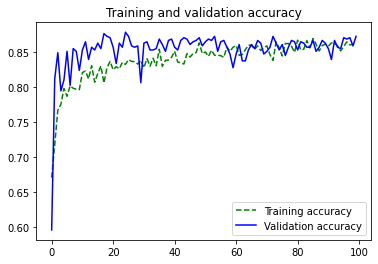

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model31_acc.png'))
plt_a.show()

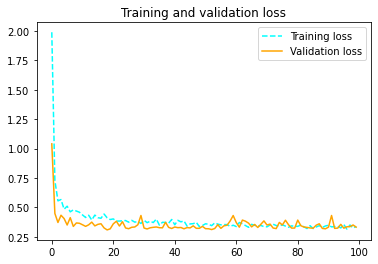

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model31_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 25
Valid accuracy [end]: 0.8730
Valid accuracy [opt]: 0.8789
Valid loss [end]: 0.3328
Valid loss [opt]: 0.3257


In [ ]:
test_model(model)

5/5 [==============================] - 1s 156ms/step - loss: 0.3759 - acc: 0.8469

---------------------------------
Accuracy: 84.69 %
Loss: 0.38
---------------------------------



###Model 4
more dense layer with Dropout 0.2 and early stopping with patient 20

In [ ]:
callback=earlyStop(20)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 21s 478ms/step - loss: 1.8391 - acc: 0.6219 - val_loss: 0.5072 - val_acc: 0.7734
Epoch 2/100
33/33 [==============================] - 14s 419ms/step - loss: 0.6744 - acc: 0.7081 - val_loss: 0.4249 - val_acc: 0.8320
Epoch 3/100
33/33 [==============================] - 14s 412ms/step - loss: 0.5286 - acc: 0.7616 - val_loss: 0.3691 - val_acc: 0.8496
Epoch 4/100
33/33 [==============================] - 14s 419ms/step - loss: 0.5910 - acc: 0.7418 - val_loss: 0.4016 - val_acc: 0.8438
Epoch 5/100
33/33 [==============================] - 14s 418ms/step - loss: 0.4832 - acc: 0.7861 - val_loss: 0.3811 - val_acc: 0.8320
Epoch 6/100
33/33 [==============================] - 14s 418ms/step - loss: 0.4900 - acc: 0.7837 - val_loss: 0.3486 - val_acc: 0.8516
Epoch 7/100
33/33 [==============================] - 14s 415ms/step - loss: 0.4626 - acc: 0.8039 - val_loss: 0.3898 - val_acc: 0.8223
Epoch 8/100
33/33 [==============================] - 14s 418ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model4.h5'))

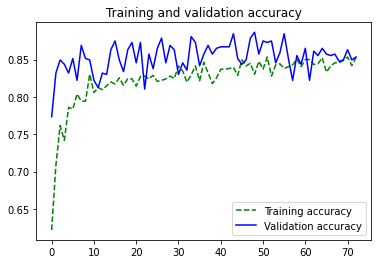

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model4_acc.png'))
plt_a.show()

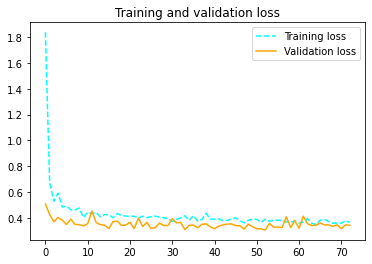

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model4_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 73
Epoch [opt]: 49
Valid accuracy [end]: 0.8535
Valid accuracy [opt]: 0.8867
Valid loss [end]: 0.3419
Valid loss [opt]: 0.3499


In [ ]:
test_model(model)

5/5 [==============================] - 1s 142ms/step - loss: 0.3696 - acc: 0.8406

---------------------------------
Accuracy: 84.06 %
Loss: 0.37
---------------------------------



###Model 5
Model 1 with batch size 32

In [ ]:
callback=earlyStop(30)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
BATCH_SIZE=32

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 29s 362ms/step - loss: 1.2963 - acc: 0.6784 - val_loss: 0.9980 - val_acc: 0.6309
Epoch 2/100
66/66 [==============================] - 20s 304ms/step - loss: 0.6174 - acc: 0.7429 - val_loss: 0.4227 - val_acc: 0.8027
Epoch 3/100
66/66 [==============================] - 29s 438ms/step - loss: 0.5179 - acc: 0.7851 - val_loss: 0.5769 - val_acc: 0.7480
Epoch 4/100
66/66 [==============================] - 23s 350ms/step - loss: 0.5165 - acc: 0.7884 - val_loss: 0.5498 - val_acc: 0.7656
Epoch 5/100
66/66 [==============================] - 15s 225ms/step - loss: 0.4968 - acc: 0.7979 - val_loss: 0.3891 - val_acc: 0.8223
Epoch 6/100
66/66 [==============================] - 23s 346ms/step - loss: 0.4731 - acc: 0.8031 - val_loss: 0.3554 - val_acc: 0.8516
Epoch 7/100
66/66 [==============================] - 24s 364ms/step - loss: 0.4396 - acc: 0.8207 - val_loss: 0.3823 - val_acc: 0.8242
Epoch 8/100
66/66 [==============================] - 22s 339ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model5.h5'))

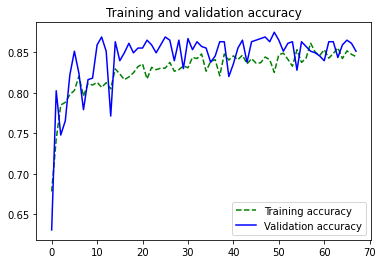

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model5_acc.png'))
plt_a.show()

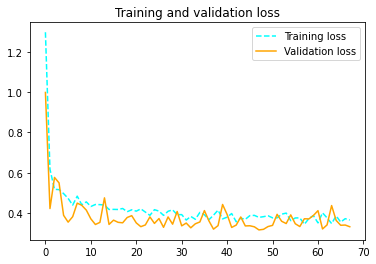

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model5_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 68
Epoch [opt]: 50
Valid accuracy [end]: 0.8516
Valid accuracy [opt]: 0.8750
Valid loss [end]: 0.3326
Valid loss [opt]: 0.3334


In [ ]:
test_model(model)

10/10 [==============================] - 1s 89ms/step - loss: 0.3907 - acc: 0.8313

---------------------------------
Accuracy: 83.13 %
Loss: 0.39
---------------------------------



###Model 6
Model 1 with batch size 64 and different optimizers and learning rate: 

*   RMSprop with learning rate 0.0001
*   Adam with learning rate 0.001
*   Adam with learning rate 0.0001



In [ ]:
callback=earlyStop(20)

In [ ]:
BATCH_SIZE=64

####6.1

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 23s 469ms/step - loss: 0.6478 - acc: 0.6922 - val_loss: 0.4288 - val_acc: 0.8145
Epoch 2/100
33/33 [==============================] - 13s 405ms/step - loss: 0.4852 - acc: 0.7741 - val_loss: 0.3718 - val_acc: 0.8418
Epoch 3/100
33/33 [==============================] - 14s 417ms/step - loss: 0.4528 - acc: 0.7938 - val_loss: 0.3634 - val_acc: 0.8281
Epoch 4/100
33/33 [==============================] - 14s 410ms/step - loss: 0.4378 - acc: 0.8078 - val_loss: 0.3406 - val_acc: 0.8438
Epoch 5/100
33/33 [==============================] - 14s 407ms/step - loss: 0.4308 - acc: 0.8160 - val_loss: 0.3291 - val_acc: 0.8574
Epoch 6/100
33/33 [==============================] - 14s 432ms/step - loss: 0.4214 - acc: 0.8044 - val_loss: 0.3268 - val_acc: 0.8555
Epoch 7/100
33/33 [==============================] - 14s 409ms/step - loss: 0.4064 - acc: 0.8145 - val_loss: 0.3295 - val_acc: 0.8438
Epoch 8/100
33/33 [==============================] - 13s 404ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model61.h5'))

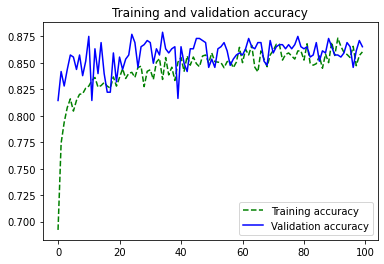

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model61_acc.png'))
plt_a.show()

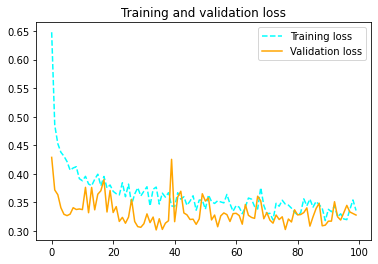

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model61_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 35
Valid accuracy [end]: 0.8652
Valid accuracy [opt]: 0.8789
Valid loss [end]: 0.3278
Valid loss [opt]: 0.3018


In [ ]:
test_model(model)

5/5 [==============================] - 1s 161ms/step - loss: 0.3723 - acc: 0.8375

---------------------------------
Accuracy: 83.75 %
Loss: 0.37
---------------------------------



####6.2

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 22s 483ms/step - loss: 1.2787 - acc: 0.6248 - val_loss: 0.5298 - val_acc: 0.7852
Epoch 2/100
33/33 [==============================] - 14s 412ms/step - loss: 0.5122 - acc: 0.7823 - val_loss: 0.4512 - val_acc: 0.8105
Epoch 3/100
33/33 [==============================] - 14s 418ms/step - loss: 0.4694 - acc: 0.8020 - val_loss: 0.4189 - val_acc: 0.8184
Epoch 4/100
33/33 [==============================] - 14s 414ms/step - loss: 0.4616 - acc: 0.7876 - val_loss: 0.4136 - val_acc: 0.8066
Epoch 5/100
33/33 [==============================] - 14s 411ms/step - loss: 0.4203 - acc: 0.8068 - val_loss: 0.3622 - val_acc: 0.8496
Epoch 6/100
33/33 [==============================] - 14s 422ms/step - loss: 0.4285 - acc: 0.7919 - val_loss: 0.3575 - val_acc: 0.8594
Epoch 7/100
33/33 [==============================] - 14s 421ms/step - loss: 0.4154 - acc: 0.8064 - val_loss: 0.3461 - val_acc: 0.8594
Epoch 8/100
33/33 [==============================] - 14s 423ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model62.h5'))

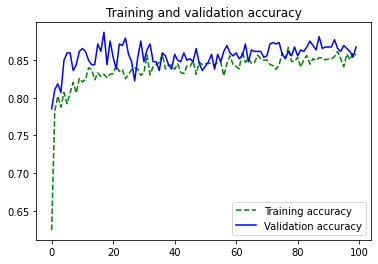

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model62_acc.png'))
plt_a.show()

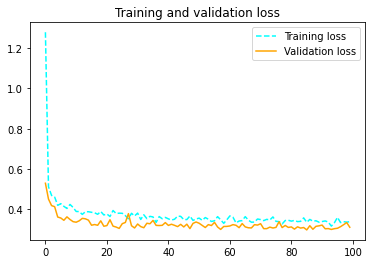

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model62_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 18
Valid accuracy [end]: 0.8672
Valid accuracy [opt]: 0.8867
Valid loss [end]: 0.3115
Valid loss [opt]: 0.3214


In [ ]:
test_model(model)

5/5 [==============================] - 1s 142ms/step - loss: 0.3403 - acc: 0.8219

---------------------------------
Accuracy: 82.19 %
Loss: 0.34
---------------------------------



####6.3

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 21s 462ms/step - loss: 0.6059 - acc: 0.6941 - val_loss: 0.4501 - val_acc: 0.8125
Epoch 2/100
33/33 [==============================] - 13s 400ms/step - loss: 0.4685 - acc: 0.7895 - val_loss: 0.3996 - val_acc: 0.8184
Epoch 3/100
33/33 [==============================] - 13s 401ms/step - loss: 0.4507 - acc: 0.7958 - val_loss: 0.3691 - val_acc: 0.8340
Epoch 4/100
33/33 [==============================] - 13s 402ms/step - loss: 0.4411 - acc: 0.8020 - val_loss: 0.3639 - val_acc: 0.8262
Epoch 5/100
33/33 [==============================] - 13s 400ms/step - loss: 0.4324 - acc: 0.8121 - val_loss: 0.3354 - val_acc: 0.8750
Epoch 6/100
33/33 [==============================] - 13s 402ms/step - loss: 0.4190 - acc: 0.8141 - val_loss: 0.3352 - val_acc: 0.8789
Epoch 7/100
33/33 [==============================] - 13s 400ms/step - loss: 0.3961 - acc: 0.8208 - val_loss: 0.3368 - val_acc: 0.8672
Epoch 8/100
33/33 [==============================] - 13s 402ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model63.h5'))

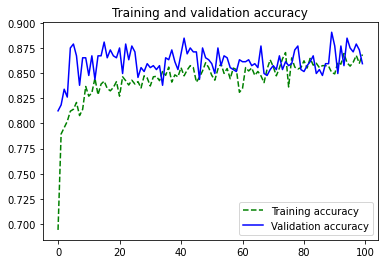

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model63_acc.png'))
plt_a.show()

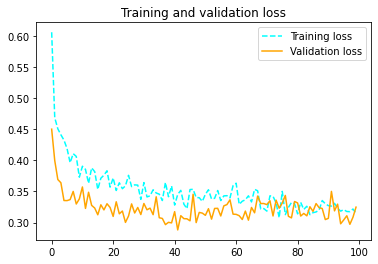

In [ ]:
plt_l = plot_loss(history)
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model63_loss.png'))
plt_l.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 90
Valid accuracy [end]: 0.8594
Valid accuracy [opt]: 0.8906
Valid loss [end]: 0.3247
Valid loss [opt]: 0.3047


In [ ]:
test_model(model)

5/5 [==============================] - 1s 146ms/step - loss: 0.3296 - acc: 0.8656

---------------------------------
Accuracy: 86.56 %
Loss: 0.33
---------------------------------



##Fine Tuning

###Model 7
Model 6.3 with last level unlocked and Adam optimizer with learning rate 0.0001

In [ ]:
callback=earlyStop(25)

In [ ]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 24s 457ms/step - loss: 0.6143 - acc: 0.6898 - val_loss: 0.4311 - val_acc: 0.8164
Epoch 2/100
33/33 [==============================] - 14s 414ms/step - loss: 0.4325 - acc: 0.7982 - val_loss: 0.3676 - val_acc: 0.8359
Epoch 3/100
33/33 [==============================] - 14s 412ms/step - loss: 0.4013 - acc: 0.8276 - val_loss: 0.3995 - val_acc: 0.8066
Epoch 4/100
33/33 [==============================] - 14s 416ms/step - loss: 0.4017 - acc: 0.8223 - val_loss: 0.3455 - val_acc: 0.8555
Epoch 5/100
33/33 [==============================] - 14s 417ms/step - loss: 0.3796 - acc: 0.8314 - val_loss: 0.3626 - val_acc: 0.8418
Epoch 6/100
33/33 [==============================] - 14s 413ms/step - loss: 0.3830 - acc: 0.8338 - val_loss: 0.3661 - val_acc: 0.8477
Epoch 7/100
33/33 [==============================] - 15s 442ms/step - loss: 0.3573 - acc: 0.8444 - val_loss: 0.3520 - val_acc: 0.8457
Epoch 8/100
33/33 [==============================] - 14s 418ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model7.h5'))

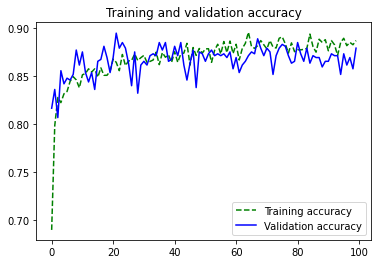

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model7_acc.png'))

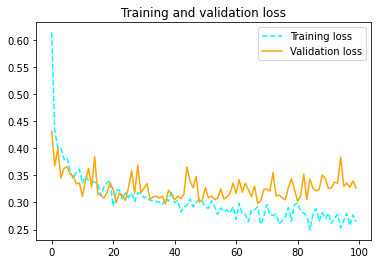

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model7_loss.png'))

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 22
Valid accuracy [end]: 0.8789
Valid accuracy [opt]: 0.8945
Valid loss [end]: 0.3267
Valid loss [opt]: 0.2995


In [ ]:
test_model(model)

5/5 [==============================] - 1s 163ms/step - loss: 0.3276 - acc: 0.8625

---------------------------------
Accuracy: 86.25 %
Loss: 0.33
---------------------------------



###Model 8
Model 6.3 with more level unlocked and Adam optimizer with learning rate 0.0001

In [ ]:
callback=earlyStop(30)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_87 ':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
33/33 [==============================] - 43s 732ms/step - loss: 0.5515 - acc: 0.7322 - val_loss: 0.4402 - val_acc: 0.8125
Epoch 2/100
33/33 [==============================] - 14s 422ms/step - loss: 0.4849 - acc: 0.7934 - val_loss: 0.3867 - val_acc: 0.8262
Epoch 3/100
33/33 [==============================] - 15s 443ms/step - loss: 0.4732 - acc: 0.7832 - val_loss: 0.3850 - val_acc: 0.8184
Epoch 4/100
33/33 [==============================] - 14s 422ms/step - loss: 0.4325 - acc: 0.8068 - val_loss: 0.3590 - val_acc: 0.8340
Epoch 5/100
33/33 [==============================] - 14s 414ms/step - loss: 0.4029 - acc: 0.8198 - val_loss: 0.3449 - val_acc: 0.8340
Epoch 6/100
33/33 [==============================] - 14s 412ms/step - loss: 0.4108 - acc: 0.8179 - val_loss: 0.3523 - val_acc: 0.8398
Epoch 7/100
33/33 [==============================] - 16s 476ms/step - loss: 0.4010 - acc: 0.8271 - val_loss: 0.3550 - val_acc: 0.8418
Epoch 8/100
33/33 [==============================] - 14s 412ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model8.h5'))

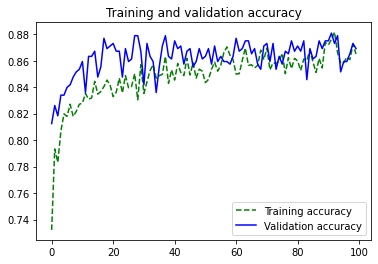

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model8_acc.png'))

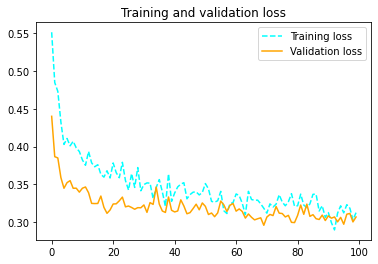

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model8_loss.png'))

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 92
Valid accuracy [end]: 0.8691
Valid accuracy [opt]: 0.8809
Valid loss [end]: 0.3068
Valid loss [opt]: 0.3052


In [ ]:
test_model(model)

5/5 [==============================] - 1s 149ms/step - loss: 0.3339 - acc: 0.8469

---------------------------------
Accuracy: 84.69 %
Loss: 0.33
---------------------------------



###Model 9
Model 6.3 with 200 epochs

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=200,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/200
33/33 [==============================] - 21s 489ms/step - loss: 0.5925 - acc: 0.7172 - val_loss: 0.4534 - val_acc: 0.8086
Epoch 2/200
33/33 [==============================] - 14s 426ms/step - loss: 0.4706 - acc: 0.7919 - val_loss: 0.3967 - val_acc: 0.8301
Epoch 3/200
33/33 [==============================] - 14s 439ms/step - loss: 0.4288 - acc: 0.8198 - val_loss: 0.3753 - val_acc: 0.8398
Epoch 4/200
33/33 [==============================] - 14s 428ms/step - loss: 0.4202 - acc: 0.8097 - val_loss: 0.3694 - val_acc: 0.8418
Epoch 5/200
33/33 [==============================] - 14s 430ms/step - loss: 0.4268 - acc: 0.8011 - val_loss: 0.3617 - val_acc: 0.8262
Epoch 6/200
33/33 [==============================] - 14s 418ms/step - loss: 0.4075 - acc: 0.8213 - val_loss: 0.3518 - val_acc: 0.8418
Epoch 7/200
33/33 [==============================] - 14s 423ms/step - loss: 0.3923 - acc: 0.8256 - val_loss: 0.3380 - val_acc: 0.8438
Epoch 8/200
33/33 [==============================] - 14s 415ms

In [ ]:
model.save(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model9.h5'))

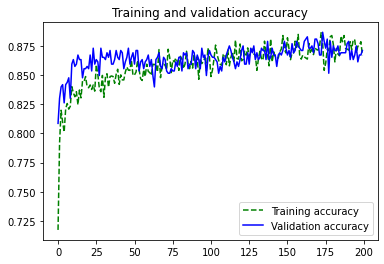

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model9_acc.png'))

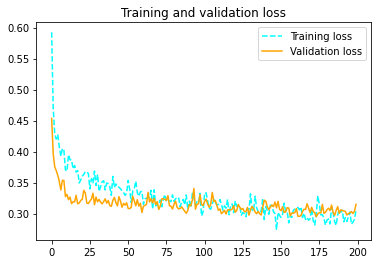

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_inceptionv3_model9_loss.png'))

In [ ]:
print_opt_results(history)

Epoch [end]: 200
Epoch [opt]: 174
Valid accuracy [end]: 0.8711
Valid accuracy [opt]: 0.8867
Valid loss [end]: 0.3149
Valid loss [opt]: 0.2949


In [ ]:
test_model(model)

5/5 [==============================] - 1s 161ms/step - loss: 0.3314 - acc: 0.8406

---------------------------------
Accuracy: 84.06 %
Loss: 0.33
---------------------------------



# Print AUC Best Model (3)

###Model 6.3

In [ ]:
model_best = load_model(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model63.h5'))

In [ ]:
test_model(model_best)

5/5 [==============================] - 13s 148ms/step - loss: 0.3212 - acc: 0.8719

---------------------------------
Accuracy: 87.19 %
Loss: 0.32
---------------------------------



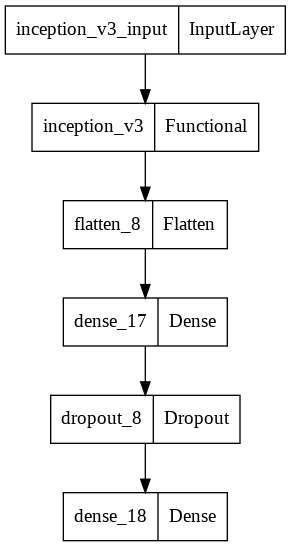

In [ ]:
plot_model(model_best)

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       179
         1.0       0.87      0.84      0.85       157

    accuracy                           0.87       336
   macro avg       0.87      0.86      0.87       336
weighted avg       0.87      0.87      0.87       336



Text(0.5, -25.558134854838144, 'Predicted label')

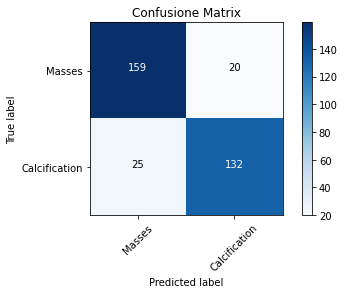

In [ ]:
classes = ["Masses", "Calcification"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+4,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

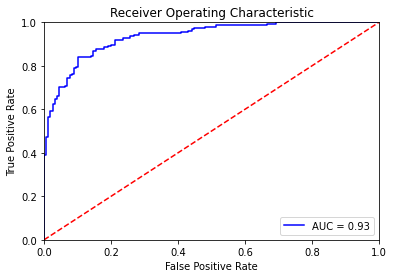

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###Model 7

In [ ]:
model_best = load_model(os.path.join(MODEL_PATH,'calcmasses_inceptionv3_model7.h5'))

In [ ]:
test_model(model_best)

5/5 [==============================] - 2s 158ms/step - loss: 0.3253 - acc: 0.8625

---------------------------------
Accuracy: 86.25 %
Loss: 0.33
---------------------------------



(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       179
         1.0       0.83      0.89      0.86       157

    accuracy                           0.87       336
   macro avg       0.87      0.87      0.87       336
weighted avg       0.87      0.87      0.87       336



Text(0.5, -6.819805153394636, 'Predicted label')

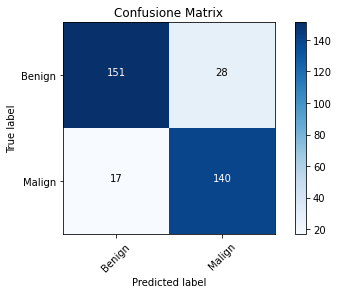

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+4,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

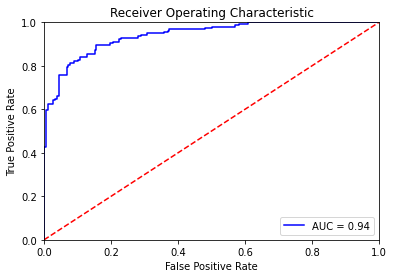

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()